In [22]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from math import floor
from warnings import filterwarnings

filterwarnings("ignore")
%run "Black&scholes.ipynb"
%run "monte_carlo.ipynb"
%run "mle.ipynb"

In [4]:
def get_data(ticker, start, end, period):
    ticker = yf.Ticker(ticker)
    df = ticker.history(start=start, end=end, period=period)
    returns = df.Close.pct_change()
    log_returns = (np.log(df.Close.shift(1)) - np.log(df.Close)).dropna()
    return np.mean(log_returns), np.std(log_returns), log_returns

In [5]:
mu_0, sigma_0, sp_returns =  get_data(ticker="^GSPC", start="2020-01-01", end="2020-12-31", period="1d")

#### a) Estimate the model parameters and corresponding confidence intervals using S&P Stock Market Index daily data from January 1 to December 31, 2020. Note: Use maximum likelihood methods for the estimation of parameters.


In [6]:
params_mle = minimize(log_likelihood, x0=[mu_0, sigma_0], args=(sp_returns,), method='Nelder-Mead')['x']
mu_mle, sigma_mle = params_mle

# Calculate the standard errors of the estimated parameters
results = sm.GLS(sp_returns, sm.tools.add_constant(sp_returns), sigma=abs(sigma_mle)).fit()
se_mu = results.bse[0]
se_sigma = results.bse[1]

# # Calculate 95% confidence intervals
mu_ci = norm.interval(0.99, loc=mu_mle, scale=se_mu)
sigma_ci = norm.interval(0.99, loc=sigma_mle, scale=se_sigma)

In [7]:
print("Daily return MLE estimation: ", round(mu_mle, 5))
print("C.Interval 95%;", f"CI_95% = [{round(mu_ci[0], 5)}, {round(mu_ci[1], 5)}]")
print("Daily Standard Deviation of returns MLE estimation: ", round(sigma_mle, 2))
print("C.Interval 95%;", f"CI_95% = [{round(sigma_ci[0], 2)}, {round(sigma_ci[1], 2)}]")

Daily return MLE estimation:  -0.00054
C.Interval 95%; CI_95% = [-0.00054, -0.00054]
Daily Standard Deviation of returns MLE estimation:  0.02
C.Interval 95%; CI_95% = [0.02, 0.02]


In [8]:
print("Annual return MLE estimation: ", round(mu_mle*252, 5))
print("C.Interval 95%;", f"CI_95% = [{round(mu_ci[0]*252, 5)}, {round(mu_ci[1]*252, 5)}]")
print("Annual Standard Deviation of returns MLE estimation: ", round(sigma_mle*np.sqrt(252), 2))
print("C.Interval 95%;", f"CI_95% = [{round(sigma_ci[0]*np.sqrt(252), 7)}, {round(sigma_ci[1]*np.sqrt(252), 7)}]")

Annual return MLE estimation:  -0.13643
C.Interval 95%; CI_95% = [-0.13643, -0.13643]
Annual Standard Deviation of returns MLE estimation:  0.35
C.Interval 95%; CI_95% = [0.3474244, 0.3474244]


#### b) Consider an European-style Call and a Put option contracts with the following parameters:
* Strike Price : 4000
* Underlying asset price : 3934.83 
* Maturity date : 21/09/2021
* Trade Date : 15/02/2021
* Risk-free interest rate : 3% 
* Dividend yield : 1%

#### c) Estimate the Call and Put option prices using the generalized Black-Scholes formula 

In [9]:
#Parameters
date_format = "%d/%m/%Y"

date1 = datetime.strptime("21/09/2021", date_format)
date2 = datetime.strptime("15/02/2021", date_format)

delta = date1 - date2

S = 3934.83
K = 4000.00
T = delta.days/252
r = 0.03
q = 0.01
sigma = sigma_mle*np.sqrt(252)
call = bs_call(S, K, T, q, r, sigma)
put = bs_put(S, K, T, q, r, sigma)

In [10]:
print(f"The value of the call option using the analytic BSM formula is : {round(call, 2)} USD")

The value of the call option using the analytic BSM formula is : 502.19 USD


In [11]:
print(f"The value of the put option using the analytic BSM formula is : {round(put, 2)} USD")

The value of the put option using the analytic BSM formula is : 498.78 USD


#### d) Confirm that the put-call parity holds.

In [12]:
round(call+K*np.exp(-r*T), 2)

4399.72

In [13]:
round(put+S* np.exp(-q*T), 2)

4399.72

In [14]:
put_call_parity = round(call+K*np.exp(-r*T), 2) == round(put+S* np.exp(-q*T), 2)
if put_call_parity:
    print("Put call parity holds")
else:
    print("Premiums are inconsistent with put call parity")

Put call parity holds


#### e) Estimate and analyse the Greeks (e.g., delta, gamma, theta, ….) for both contracts and simulate a delta hedging strategy.

##### Call 

In [15]:
call_delta_ = round(call_delta(S, K, T, q, r, sigma), 2)
call_gamma_ =round(call_gamma(S, K, T, q, r, sigma), 5)
call_vega_ = round(call_vega(S, K, T, q, r, sigma), 2)
call_theta_ = round(call_theta(S, K, T, q, r, sigma)/252, 2)
call_rho_ = round(call_rho(S, K, T, q, r, sigma), 2)
print(f'Call Greek: delta = {call_delta_} (per USD)')
print(f'Call Greek: gamma = {call_gamma_} (per USD)')
print(f'Call Greek: vega = {call_vega_/100} (per %)')
print(f'Call Greek: theta = {call_theta_} (per trading day)')
print(f'Call Greek: rho = {call_rho_/100} (per %)')

Call Greek: delta = 0.56 (per USD)
Call Greek: gamma = 0.00031 (per USD)
Call Greek: vega = 14.2806 (per %)
Call Greek: theta = -1.26 (per trading day)
Call Greek: rho = 14.7305 (per %)


##### Put 

In [16]:
put_delta_ = round(put_delta(S, K, T, q, r, sigma), 2)
put_gamma_ =round(put_gamma(S, K, T, q, r, sigma), 5)
put_vega_ = round(put_vega(S, K, T, q, r, sigma), 2)
put_theta_ = round(put_theta(S, K, T, q, r, sigma)/252, 2)
put_rho_ = round(put_rho(S, K, T, q, r, sigma), 2)
print(f'Put Greek: delta = {put_delta_} (per USD)')
print(f'Put Greek: gamma = {put_gamma_} (per USD)')
print(f'Put Greek: vega = {put_vega_/100} (per %)')
print(f'Put Greek: theta = {put_theta_} (per trading day)')
print(f'Put Greek: rho = {put_rho_/100} (per %)')

Put Greek: delta = -0.43 (per USD)
Put Greek: gamma = 0.00031 (per USD)
Put Greek: vega = 14.2806 (per %)
Put Greek: theta = -0.95 (per trading day)
Put Greek: rho = -18.9862 (per %)


##### Delta-neutral portfolio (Dynamic Hedging)

Approach: 
* We will start allocating an initial capital of 100,000 USD, take our first 10 underlying asset random walks and simulate a delta neutral trading strategy with daily rebalancing.
* Assuming no transaction costs
* Fractional trading allowed 

In [17]:
path_, _, _ = monte_carlo_vectorized(S, K, sigma, r, q, T, int(delta.days), 50000, 42)
path_.shape

(218, 50000)

#### $\pi_{t} + w_{1}\pi_{t} - S \Delta_{P} \times (\frac{-w_{1}\pi_{t}}{P}) = 0$

* $\pi_{t}$: Balance at time t

* $w_{1}$: Weight of the portfolio self financed with short sell of puts

* $S$ : index price

* $P$ : put price

* $\Delta_{P}$ : put delta

* $(\frac{-w_{1}\pi_{t}}{P})$ : number of puts sold short

* $(\pi_{t} + w_{1}\pi_{t})$ : Amount available to purchase shares

* $S \Delta_{P} \times (\frac{-w_{1}\pi_{t}}{P})$ : Amount of purchased shares

##### Solving in order of $w_{1}$, yields:

### $w_{1}=-\frac{\pi_{t}}{(\pi_{t}+ \frac{S \times \Delta_{P} \times \pi_{t}}{P})}$

In [18]:
balance = 100000
w1 = -balance/(balance + (S*put_delta_*balance/put))


n_of_puts_S = floor(balance*w1/put)

print(f"Delta neutral, self-financing portflio at time 0, is: short {n_of_puts_S} puts and going long {(-put_delta_) * n_of_puts_S} index contracts (allocating all our available capital)")

Delta neutral, self-financing portflio at time 0, is: short 83 puts and going long 35.69 index contracts (allocating all our available capital)


##### We Know our upper bound. But if our delta goes even down?! We would not have more capital to rebalance our portfolio (buy more shares). In order to be able to rebalance (purchase more shares), we will keep a safety margin of 10 put options. 
* A priori it seemed a correct doing though as we will see in the appendix, a delta neutral strategy is path dependent, i.e. even with this safety margin and with others even larger we would run out of money and would be forced to liquidate our position in some paths.
* If we add more paths and compute the expected value of the terminal state, the portfolio should approximately yield the riskless rate (properly discounted by the dividend yield) used in the exercise, since this is the economic argument of the BSM formula.
* The formula is extremely fragile to a realistic scenario and to the point of view of someone with limited and narrow capital.  

In [19]:
n_of_puts_S = floor(balance*w1/put) - 10
exc_capital = round(balance + n_of_puts_S*put -  S*(-put_delta_*n_of_puts_S), 2)
print(f"Delta neutral, self-financing portflio at time 0, is: short {n_of_puts_S} puts and going long {-put_delta_ * n_of_puts_S}, we are left over with a capital of {exc_capital} USD to rebalance")

Delta neutral, self-financing portflio at time 0, is: short 73 puts and going long 31.39, we are left over with a capital of 12896.71 USD to rebalance


In [18]:
def rebalance(df:pd.DataFrame, col1:str, col2:str, col3:str, col4:str, col5:str, n_of_puts_S : int = n_of_puts_S) -> pd.Series:
    for i in range(1, len(df)):
        df[col1][i] = df[col1][i-1] - df[col2][i]*df[col3][i]
        if i == len(df)-1:
            df[col1][i] += df[col4][i] * df[col3][i] - df[col5][i] * n_of_puts_S
    return df[col1]


def simulate_delta_neutral(paths: np.array, n: int, K:int, T:float, sigma:float, r:float, q:float, delta_func = put_delta, BS_func = bs_put, balance : int = balance, n_of_puts_S : int = n_of_puts_S) -> pd.DataFrame:
    paths_ = paths[:, :n]
    columns = [f"S_{i}" for i in range(n)]
    df = pd.DataFrame(data=paths_, columns=columns)
    df["dt"] = [(T) - i/252 for i in range(len(paths))]
    # assumed constants
    df["K"] = K
    df["sigma"] = sigma
    df["r"] = r
    df["q"] = q
    
    CFF = []
    deltas = []
    Sim = []
    option_val = []
    actv = []
    current_position = []
    port_delta = []
    delta_diffs = []
    
    for i in range(n):
        df[f"delta_{i}"] = df.apply(lambda row: round(delta_func(row[f"S_{i}"], row["K"]  , row["dt"]  , row["q"]  , row["r"]  , row["sigma"]), 2), axis=1)
        df[f"f_value_{i}"] = df.apply(lambda row: round(BS_func(row[f"S_{i}"], row["K"]  , row["dt"]  , row["q"]  , row["r"]  , row["sigma"]), 2), axis=1)
        df[f"delta_diff_{i}"] = df[f"delta_{i}"].shift(1) - df[f"delta_{i}"]
        df[f"shares_rebalanced_{i}"] = (df[f"delta_diff_{i}"] * n_of_puts_S)
        df[f"shares_rebalanced_{i}"].iloc[0] = (-put_delta_ * n_of_puts_S)
        df[f"shares_rebalanced_{i}"] = df[f"shares_rebalanced_{i}"]
        df[f"current_position_{i}"] = df[f"shares_rebalanced_{i}"].cumsum()
        df[f"CFF_{i}"] = 0
        df[f"CFF_{i}"][0] = balance + df[f"f_value_{i}"][0] * n_of_puts_S - df[f"S_{i}"][0] * df[f"shares_rebalanced_{i}"][0]
        df[f"CFF_{i}"] = rebalance(df, f"CFF_{i}", f"shares_rebalanced_{i}", f"S_{i}", f"current_position_{i}", f"f_value_{i}")
        df[f"current_position_{i}"].iloc[-1] = 0
        df[f"portfolio{i}_delta"] = df[f"delta_{i}"] * n_of_puts_S + df[f"current_position_{i}"]
        df[f"portfolio{i}_delta"].iloc[-1] = 0
        CFF.append(f"CFF_{i}")
        deltas.append(f"delta_{i}")
        Sim.append(f"S_{i}")
        option_val.append(f"f_value_{i}")
        actv.append(f"shares_rebalanced_{i}")
        current_position.append(f"current_position_{i}")
        port_delta.append(f"portfolio{i}_delta")
        delta_diffs.append(f"delta_diff_{i}")
        
    
    return df[CFF], df[deltas], df[Sim], df[option_val], df[actv], df[current_position], df[port_delta], df[delta_diffs]

In [19]:
CFFS, deltas, simulations, B_s_put_price, hedging_activity, Position_on_index, Portfolio_delta, delta_diff= simulate_delta_neutral(path_, 10, K, T, sigma, r, q)

#### f) Estimate the fair value of the call & put option contracts using Monte Carlo simulation methods considering 50000 simulations and compare its results with those obtained using the Black-Scholes formula.

In [20]:
_, call_, put_ = monte_carlo_vectorized(S, K, sigma, r, q, T, int(delta.days), 50000, 42)

In [21]:
print(f"The value of the Call using MC is: {round(np.mean(call_), 2)}$")

The value of the Call using MC is: 536.97$


In [22]:
print(f"The value of the Put using MC is: {round((np.mean(put_)), 2)}$")

The value of the Put using MC is: 470.19$


#### g) Estimate the Greeks (e.g., delta, gamma, theta, ….) for both contracts.


In [23]:
print(f"Call Pathwise method Greek: delta = {round(Pathwise_delta('call', S, K, path_, r, T), 2)} (per $)")
print(f"Call finite difference Greek: gamma = {round(finite_diff_gamma('call', 1,  S, K, sigma, r, q, T, int(delta.days), 10000), 5)} (per $)")
print(f"Call Pathwise method Greek: vega = {round(Pathwise_vega(S, K, path_, sigma, r, T)/100, 2)} (per %)")
print(f"Call finite difference method Greek: theta = {round(finite_diff_theta('call', 0.8,  S, K, sigma, r, q, T, int(delta.days), 10000)/252, 2)} (per trading day)")
print(f"Call finite difference Greek: rho = {round(finite_diff_rho('call', 0.07,  S, K, sigma, r, q, T, int(delta.days), 10000), 2)} (per %) ")

Call Pathwise method Greek: delta = 0.56 (per $)
Call finite difference Greek: gamma = 0.00016 (per $)
Call Pathwise method Greek: vega = 13.54 (per %)
Call finite difference method Greek: theta = 1.04 (per trading day)
Call finite difference Greek: rho = 17.28 (per %) 


In [24]:
print(f"Put Pathwise method Greek: delta = {round(Pathwise_delta('put', S, K, path_, r, T), 2)} (per $)")
print(f"Put finite difference Greek: gamma = {round(finite_diff_gamma('put', 1,  S, K, sigma, r, q, T, int(delta.days), 10000), 5)} (per $)")
print(f"Put Pathwise method Greek: vega = {round(Pathwise_vega(S, K, path_, sigma, r, T)/100, 2)} (per %)")
print(f"Put finite difference method Greek: theta = {round(finite_diff_theta('put', 0.8,  S, K, sigma, r, q, T, int(delta.days), 10000)/252, 2)} (per trading day)")
print(f"Put finite difference Greek: rho = {round(finite_diff_rho('put', 0.07,  S, K, sigma, r, q, T, int(delta.days), 10000), 2)} (per %) ")

Put Pathwise method Greek: delta = -0.44 (per $)
Put finite difference Greek: gamma = 0.00016 (per $)
Put Pathwise method Greek: vega = 13.54 (per %)
Put finite difference method Greek: theta = 0.69 (per trading day)
Put finite difference Greek: rho = -16.0 (per %) 


#### h) Estimate the fair value of an American-Style Call with term sheet defined in (b) using Monte Carlo simulation methods and compare the results with that of its European-style equivalent. 

Longstaff-Schwartz (2001) american options pricing using Monte carlo with OLS (Ordinary Least Squares regression)

In [94]:
%time put_ls = longstaff_schwartz("put", path_, put_payoff, K, r, q, T, bf=8)

Wall time: 7.41 s


In [96]:
print(f"The price of the American put Option is : {round(np.mean(put_ls), 2)} USD")
print(f"The price of the European put Option is : {round(np.mean(put_payoff(path_[-1, :],K, r, q, T)), 2)} USD")
print(f"The premium of the early exercising is: {round(np.mean(put_ls)-np.mean(put_payoff(path_[-1, :],K, r, q, T)), 2)} USD")

The price of the American put Option is : 484.83 USD
The price of the European put Option is : 470.19 USD
The premium of the early exercising is: 14.64 USD


In [71]:
%time call_ls = longstaff_schwartz("call", path_, call_payoff, K, r, q, T, bf=8)

Wall time: 6.63 s


In [97]:
print(f"The price of the American put Option is : {round(np.mean(call_ls), 2)} USD")
print(f"The price of the European put Option is : {round(np.mean(call_payoff(path_[-1, :],K, r, q, T)), 2)} USD")
print(f"The premium of the early exercising is: {round(np.mean(call_ls)-np.mean(call_payoff(path_[-1, :],K, r, q, T)), 2)} USD")

The price of the American put Option is : 539.53 USD
The price of the European put Option is : 536.97 USD
The premium of the early exercising is: 2.56 USD


### Appendix 

#### Plots 

##### Historical data exploration

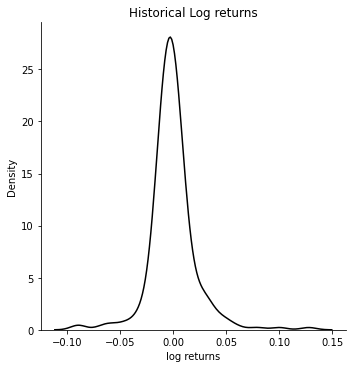

In [91]:
sns.displot(sp_returns, kind="kde", palette="husl", color="black")
plt.title("Historical Log returns")
plt.xlabel("log returns")
plt.show()

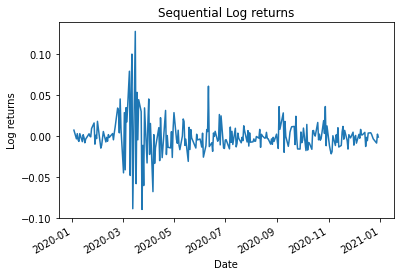

In [21]:
sp_returns.plot()
plt.title("Sequential Log returns")
plt.ylabel("Log returns")
plt.show()

##### Simulations

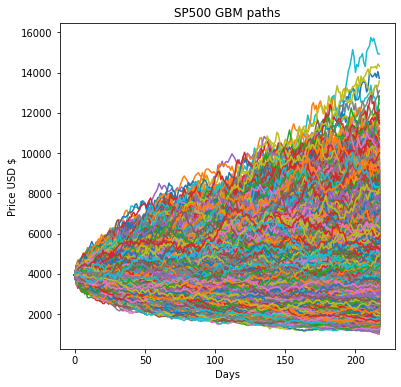

In [78]:
plt.figure(figsize=(6, 6))
plt.plot(range(path_.shape[0]), list(path_))
plt.title("SP500 GBM paths")
plt.ylabel("Price USD $")
plt.xlabel("Days")
plt.show()

##### Dynamic Hedging

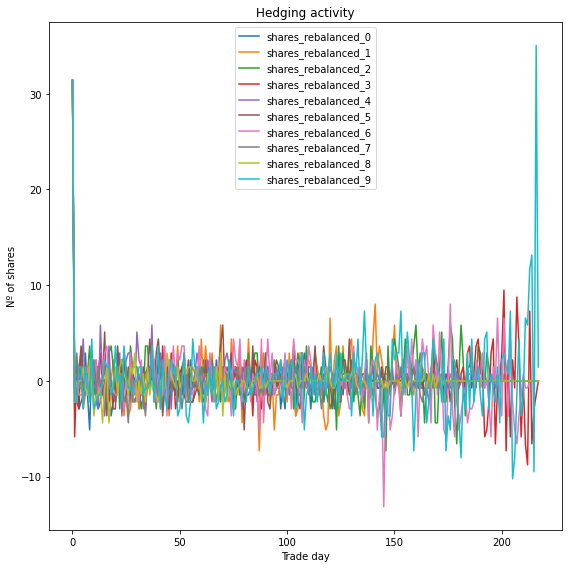

In [79]:
hedging_activity.plot(figsize=(8, 8))
plt.title("Hedging activity")
plt.xlabel("Trade day")
plt.ylabel("Nº of shares")
plt.tight_layout()
plt.show()

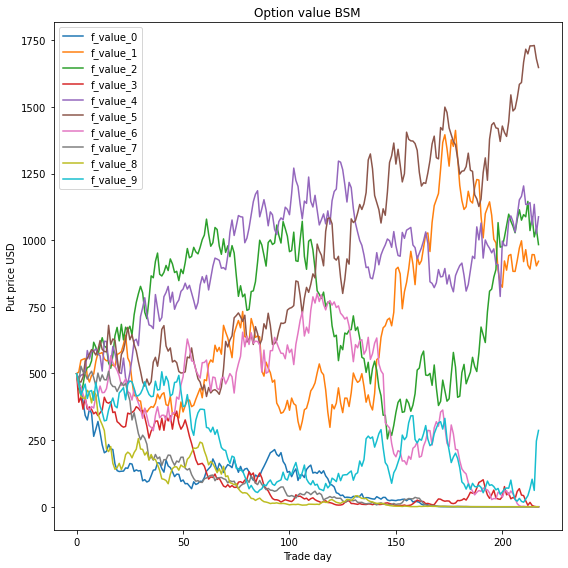

In [80]:
B_s_put_price.plot(figsize=(8, 8))
plt.title("Option value BSM")
plt.xlabel("Trade day")
plt.ylabel("Put price USD")
plt.tight_layout()
plt.show()

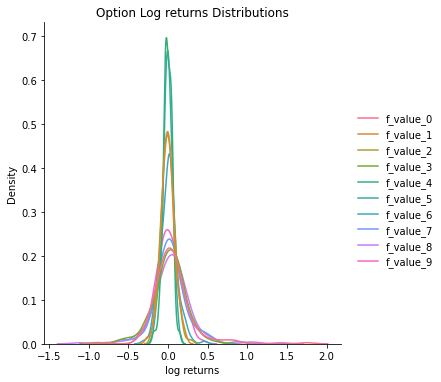

In [81]:
log_opt_returns = (np.log(B_s_put_price.shift(1)) - np.log(B_s_put_price)).dropna()
sns.displot(log_opt_returns, kind="kde", palette="husl")
plt.title("Option Log returns Distributions")
plt.xlabel("log returns")
plt.show()

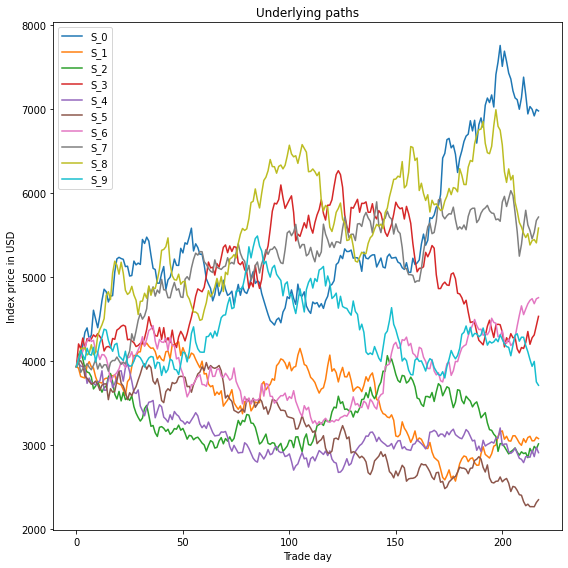

In [82]:
simulations.plot(figsize=(8, 8))
plt.title("Underlying paths")
plt.xlabel("Trade day")
plt.ylabel("Index price in USD")
plt.tight_layout()
plt.show()

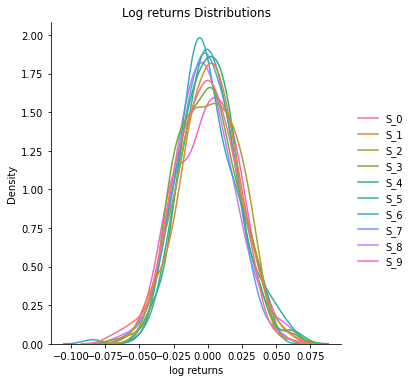

In [83]:
log_returns = (np.log(simulations.shift(1)) - np.log(simulations)).dropna()
sns.displot(log_returns, kind="kde", palette="husl")
plt.title("Log returns Distributions")
plt.xlabel("log returns")
plt.show()

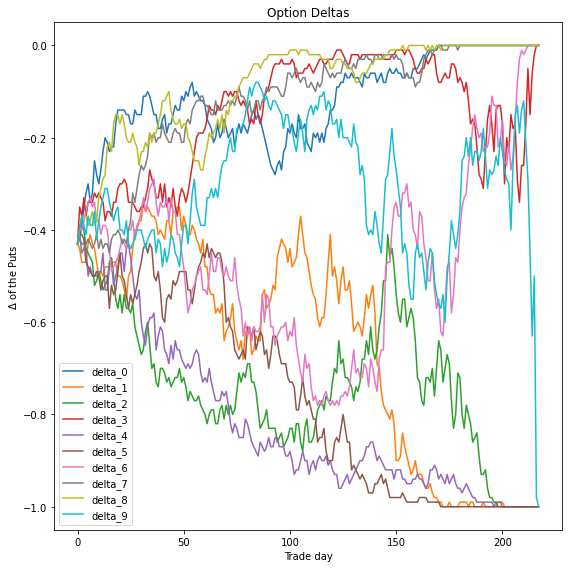

In [84]:
deltas.plot(figsize=(8, 8))
plt.title("Option Deltas")
plt.xlabel("Trade day")
plt.ylabel("$\Delta$ of the Puts")
plt.tight_layout()
plt.show()

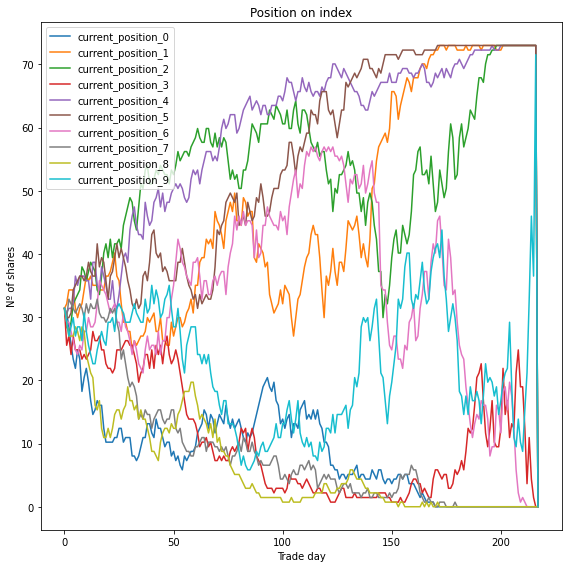

In [85]:
Position_on_index.plot(figsize=(8, 8))
plt.title("Position on index")
plt.xlabel("Trade day")
plt.ylabel("Nº of shares")
plt.tight_layout()
plt.show()

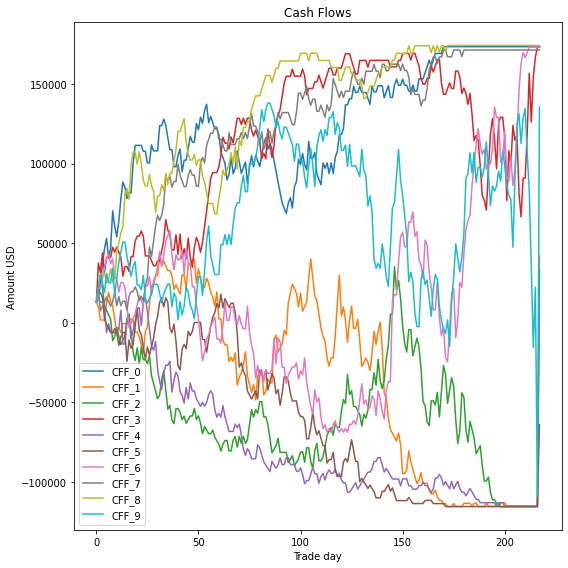

In [86]:
CFFS.plot(figsize=(8, 8))
plt.title("Cash Flows")
plt.xlabel("Trade day")
plt.ylabel("Amount USD")
plt.tight_layout()
plt.show()

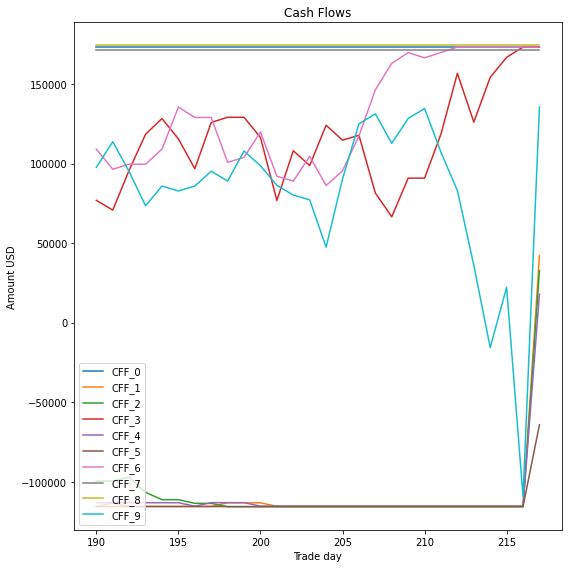

In [87]:
CFFS.iloc[190:, ].plot(figsize=(8, 8))
plt.title("Cash Flows")
plt.xlabel("Trade day")
plt.ylabel("Amount USD")
plt.tight_layout()
plt.legend(loc="lower left")
plt.show()

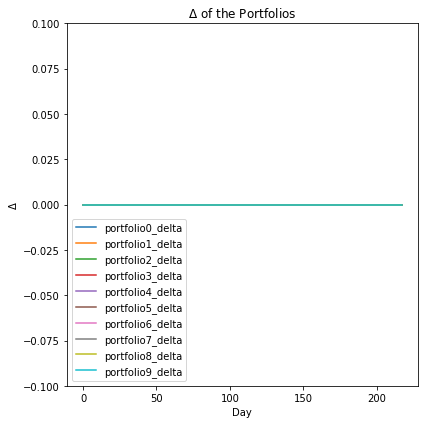

In [88]:
Portfolio_delta.plot(figsize=(6, 6))
plt.title("$\Delta$ of the Portfolios")
plt.xlabel("Day")
plt.ylim([-0.1, 0.1])
plt.ylabel("$\Delta$")
plt.tight_layout()
plt.legend(loc="lower left")
plt.show()